# 2D Diffusion Equation — Gaussian Bump

The **2D diffusion equation** describes how a quantity (heat, dye, concentration) spreads outward in two spatial dimensions over time:

$$\frac{\partial u}{\partial t} = \alpha \left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right)$$

**Where:**
- $u(t, x, y)$ = the quantity of interest (temperature, concentration) at position $(x, y)$ and time $t$
- $\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}$ = the **2D Laplacian** — measures how much $u$ at a point differs from its neighbours in all directions
- $\alpha = 0.01$ = diffusion coefficient — controls how fast the spreading happens

**Physical meaning:** Drop a hot blob in the centre of a cold metal plate. Heat flows outward in every direction equally, the blob flattens and widens, and eventually the temperature equalises across the whole plate. The Laplacian is what drives this — wherever you are hotter than your surroundings, heat flows out.

**The leap from 1D to 2D:** In 1D diffusion, spreading only happened left and right. Now it happens in all directions simultaneously. The Laplacian $\nabla^2 u$ is just the natural 2D generalisation of $\frac{\partial^2 u}{\partial x^2}$ — it asks *"how does this point compare to all its neighbours?"*

---

## This Problem Setup

**Domain:** $x \in [0, 1]$, $y \in [0, 1]$, $t \in [0, 2]$

**Initial Condition — Gaussian Bump:**

$$u(x, y, 0) = \exp\left(-\frac{(x - 0.5)^2 + (y - 0.5)^2}{2\sigma^2}\right), \quad \sigma = 0.1$$

A tight, symmetric hill of amplitude 1 sits exactly at the centre of the domain $(0.5, 0.5)$. The narrow width ($\sigma = 0.1$) means the initial gradient is steep — diffusion will spread it aggressively from the start.

**Boundary Conditions (Dirichlet):**

$$u = 0 \quad \text{on all four walls}$$

All four edges of the square are held at zero for all time — 1000 boundary points spread randomly across the left, right, bottom, and top walls (250 per edge). The bump diffuses outward and is eventually absorbed at the boundaries.

**Physics Points:** $20 \times 20 \times 20 = 8000$ interior collocation points sampled on a uniform grid across the full $(x, y, t)$ volume — this is where the PINN enforces the PDE residual.

In [ ]:
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
import optax
import copy

# ============ DOMAIN PARAMETERS ============
L = 1.0          # domain size [0, L] x [0, L]
T_final = 2.0    # time domain [0, T_final]
alpha = 0.01     # diffusion coefficient

# Initial condition: Gaussian centered at (cx, cy)
cx, cy = 0.5, 0.5
sigma = 0.1

# 1. Initial Condition points (1000 points at t=0)

key = random.PRNGKey(0)
N_ic = 2000


k1, k2 = random.split(key)
x_ic = random.uniform(k1, (N_ic, 1), minval=0.0, maxval=L)
y_ic = random.uniform(k2, (N_ic, 1), minval=0.0, maxval=L)
t_ic = jnp.zeros((N_ic, 1))

# Compute initial condition values (Gaussian Bump)
u_ic = jnp.exp(-((x_ic-cx)**2 + (y_ic-cy)**2) / (2*sigma**2))

# 2. Boundary Condition points (250 each side, total 1000 points)

k3, k4, k5, k6, k7, k8, k9, k10 = random.split(k2, 8)
N_per_edge = 250

x_left = jnp.zeros((N_per_edge, 1))
y_left = random.uniform(k3, (N_per_edge, 1), minval=0.0, maxval=L)
t_left = random.uniform(k4, (N_per_edge, 1), minval=0.0, maxval=T_final)

x_right = jnp.ones((N_per_edge, 1)) * L
y_right = random.uniform(k5, (N_per_edge, 1), minval=0.0, maxval=L)
t_right = random.uniform(k6, (N_per_edge, 1), minval=0.0, maxval=T_final)

x_bottom = random.uniform(k7, (N_per_edge, 1), minval=0.0, maxval=L)
y_bottom = jnp.zeros((N_per_edge, 1))
t_bottom = random.uniform(k8, (N_per_edge, 1), minval=0.0, maxval=T_final)  

x_top = random.uniform(k9, (N_per_edge, 1), minval=0.0, maxval=L)
y_top = jnp.ones((N_per_edge, 1)) * L
t_top = random.uniform(k10, (N_per_edge, 1), minval=0.0, maxval=T_final)

# Combine all boundary points
x_bc = jnp.concatenate([x_left, x_right, x_bottom, x_top])
y_bc = jnp.concatenate([y_left, y_right, y_bottom, y_top])
t_bc = jnp.concatenate([t_left, t_right, t_bottom, t_top])
u_bc = jnp.zeros((N_per_edge * 4, 1))  # u=0 at all boundaries

# 3. Physics points (20*20*20 = 8000 points in the interior of the domain)
t_vals = jnp.linspace(0, T_final, 20)
x_vals = jnp.linspace(0, L, 20)
y_vals = jnp.linspace(0, L, 20)
t_grid, x_grid, y_grid = jnp.meshgrid(t_vals, x_vals, y_vals)  # Shape (20, 20, 20)
t_physics = t_grid.reshape(-1, 1)  # Shape (8000, 1)
x_physics = x_grid.reshape(-1, 1)  # Shape (8000, 1)
y_physics = y_grid.reshape(-1, 1)  # Shape (8000, 1)

# Neural Network

def init_network_params(layer_sizes, key):
    """
    Initialize parameters for a fully connected network.
    
    Args:
        layer_sizes: List of layer sizes, e.g., [3, 32, 32, 32, 1] for 3 inputs, 3 hidden layers of 32 neurons, and 1 output
                    (input_dim, hidden1, hidden2, hidden3, output_dim)
        key: JAX random key for initialization
        
    Returns:
        params: List of dictionaries, each containing 'w' and 'b'
    """
    # Split random key for each layer
    keys = random.split(key, len(layer_sizes))
    
    params = []
    for i in range(len(layer_sizes) - 1):
        n_in = layer_sizes[i]
        n_out = layer_sizes[i + 1]
        
        # Split key for weights and biases
        w_key, b_key = random.split(keys[i])
        
        # Xavier initialization for weights
        params.append({
            'w': random.normal(w_key, (n_in, n_out)) * jnp.sqrt(2.0 / n_in),
            'b': jnp.zeros(n_out)
        })
    
    return params


def network(params, x):
    """
    Forward pass through the network.
    
    Args:
        params: List of layer parameters (from init_network_params)
        x: Input array, shape (batch_size, input_dim)
        
    Returns:
        Output array, shape (batch_size, output_dim)
    """
    # Process all hidden layers (all but last)
    for layer in params[:-1]:
        # Linear transformation: x @ W + b
        x = jnp.dot(x, layer['w']) + layer['b']
        # Activation function
        x = jnp.tanh(x)
    
    # Output layer (no activation)
    final_layer = params[-1]
    x = jnp.dot(x, final_layer['w']) + final_layer['b']
    
    return x


# Calculate Residual

def physics_residual_single(params, t_point, x_point, y_point, alpha):

    def u(t_val, x_val, y_val):
        txy_in = jnp.array([[t_val, x_val, y_val]])  # Shape (1, 3)
        return network(params, txy_in)[0, 0]
    
    du_dt = grad(u, argnums=0)(t_point, x_point, y_point)

    d2u_dx2 = grad(grad(u, argnums = 1), argnums=1)(t_point, x_point, y_point)
    d2u_dy2 = grad(grad(u, argnums = 2), argnums=2)(t_point, x_point, y_point)

    return du_dt - alpha * (d2u_dx2 + d2u_dy2)
    

# Vectorize to handle all physics points at once
# So vmap will call physics_residual_single 900 times, once for each (t, x, y) triple, keeping params and alpha fixed.
physics_residual_batch = vmap(physics_residual_single, in_axes=(None, 0, 0, 0, None))


# Initialize network
key = random.PRNGKey(123)
layer_sizes = [3, 32, 32, 32, 1]  # 3 inputs (t, x, y), 1 output (u)
params = init_network_params(layer_sizes, key)

# Initialize optimizer
learning_rate = 1e-3
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)


@jit
def update_step(params, opt_state, t_ic, x_ic, y_ic, u_ic, 
                t_bc, x_bc, y_bc, u_bc, t_physics, x_physics, y_physics, alpha):

    def loss_fn(params):

        # 1. Initial Condition Loss
        # Network prediction at IC points
        txy_ic = jnp.concatenate([t_ic, x_ic, y_ic], axis=1)  # Combine t, x, and y
        u_pred_ic = network(params, txy_ic)
        ic_loss = jnp.mean((u_pred_ic - u_ic)**2)
        
        # 2. Boundary Condition Loss
        txy_bc = jnp.concatenate([t_bc, x_bc, y_bc], axis=1)
        u_pred_bc = network(params, txy_bc)
        bc_loss = jnp.mean((u_pred_bc - u_bc)**2)
        
        # 3. Physics Loss
        physics_residuals = physics_residual_batch(params, 
                                                t_physics.ravel(), 
                                                x_physics.ravel(), 
                                                y_physics.ravel(), 
                                                alpha)
        physics_loss = jnp.mean(physics_residuals**2) 

        # return total loss plus a tuple of the individual components as auxiliary data
        return ic_loss + bc_loss + physics_loss, (ic_loss, bc_loss, physics_loss)
    
        # Compute loss and gradients; use has_aux=True so we can extract the individual losses
    (loss_val, indivicual_loss), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
    
    # Update parameters
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss_val, indivicual_loss


# Training parameters
num_iterations = 40000
save_every = 150  # Save every 150 iterations
print_every = 1000

# Storage for snapshots
snapshots = []
snapshot_iterations = []

# Prepare physics points (flatten for vmap)
t_phys_flat = t_physics.ravel()
x_phys_flat = x_physics.ravel()
y_phys_flat = y_physics.ravel()

# Training loop
losses = []
losses_ic = []
losses_bc = []
losses_physics = []
for i in range(num_iterations):
    params, opt_state, loss, individual_losses = update_step(
        params, opt_state,
        t_ic, x_ic, y_ic, u_ic,
        t_bc, x_bc, y_bc, u_bc,
        t_phys_flat, x_phys_flat, y_phys_flat,
        alpha
    )
    
    losses.append(loss)
    losses_ic.append(individual_losses[0])
    losses_bc.append(individual_losses[1])
    losses_physics.append(individual_losses[2])


    # Save snapshot every 150 iterations
    if (i + 1) % save_every == 0:
        # Make a copy of params (important!)
        snapshots.append(copy.deepcopy(params))
        snapshot_iterations.append(i + 1)

    # Print progress every 1000 iterations
    if (i + 1) % print_every == 0:
        print(f"Iteration {i+1}/{num_iterations}, Loss: {loss:.6f}")
        print(f"  IC Loss: {individual_losses[0]:.6f}, BC Loss: {individual_losses[1]:.6f}, Physics Loss: {individual_losses[2]:.6f}")


Iteration 1000/40000, Loss: 0.011761
  IC Loss: 0.010664, BC Loss: 0.000319, Physics Loss: 0.000779
Iteration 2000/40000, Loss: 0.001671
  IC Loss: 0.000927, BC Loss: 0.000048, Physics Loss: 0.000697
Iteration 3000/40000, Loss: 0.000555
  IC Loss: 0.000245, BC Loss: 0.000030, Physics Loss: 0.000281
Iteration 4000/40000, Loss: 0.000287
  IC Loss: 0.000094, BC Loss: 0.000027, Physics Loss: 0.000166
Iteration 5000/40000, Loss: 0.000174
  IC Loss: 0.000049, BC Loss: 0.000012, Physics Loss: 0.000113
Iteration 6000/40000, Loss: 0.000193
  IC Loss: 0.000052, BC Loss: 0.000040, Physics Loss: 0.000101
Iteration 7000/40000, Loss: 0.000137
  IC Loss: 0.000030, BC Loss: 0.000027, Physics Loss: 0.000080
Iteration 8000/40000, Loss: 0.000098
  IC Loss: 0.000022, BC Loss: 0.000015, Physics Loss: 0.000061
Iteration 9000/40000, Loss: 0.000067
  IC Loss: 0.000016, BC Loss: 0.000006, Physics Loss: 0.000045
Iteration 10000/40000, Loss: 0.000059
  IC Loss: 0.000013, BC Loss: 0.000007, Physics Loss: 0.000039

## Visualizations

## Heatmaps

/tmp/ipykernel_4113/3114090635.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


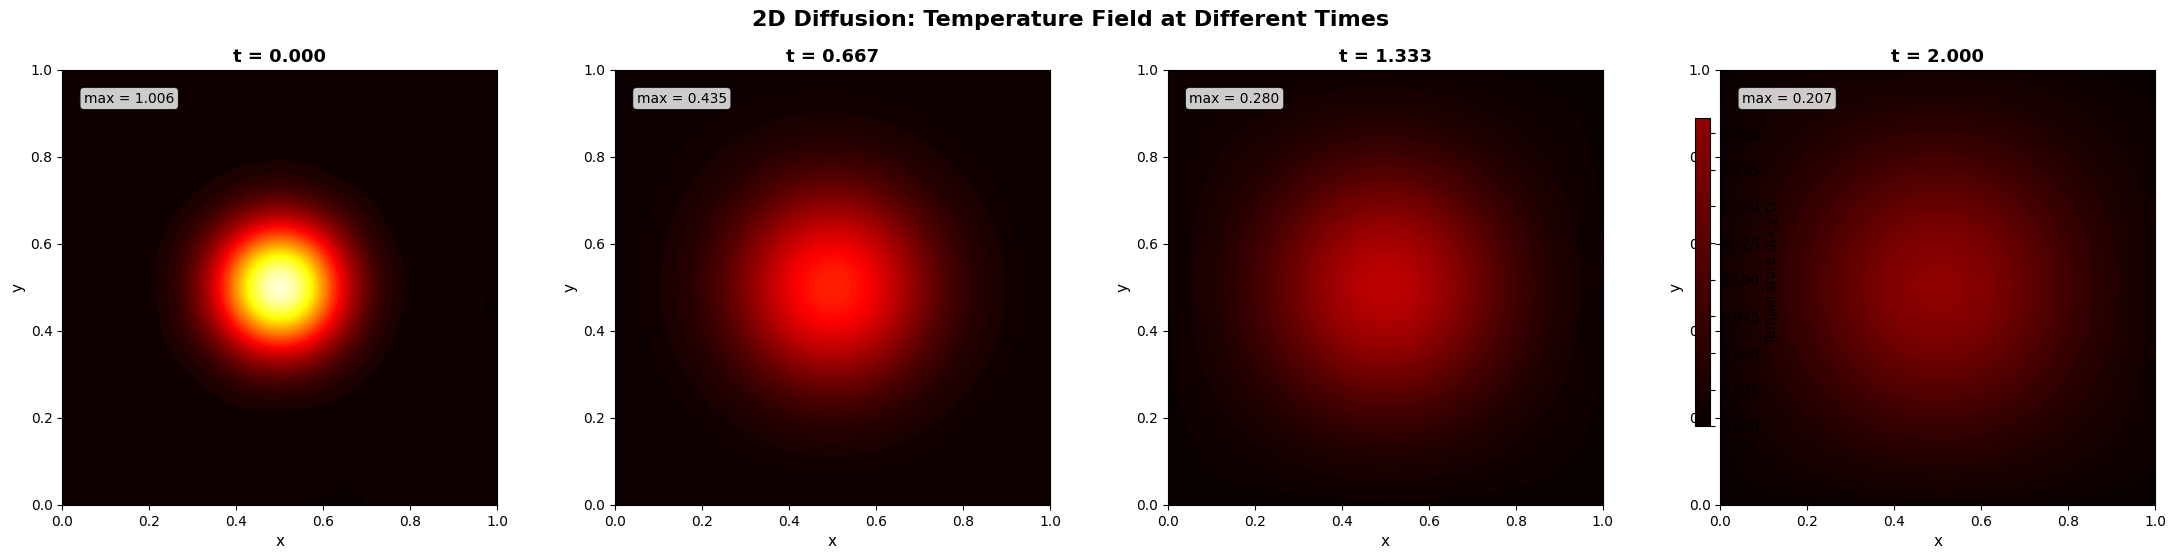

Saved: time_slices.png


In [10]:

import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
import numpy as np

# ============================================================
# HELPER: Evaluate network on a 2D grid at a fixed time
# ============================================================
def eval_on_grid(params, network, t_val, L, N_eval=100):
    """Evaluate u(x, y, t_val) on an N_eval x N_eval grid."""
    x_eval = jnp.linspace(0, L, N_eval)
    y_eval = jnp.linspace(0, L, N_eval)
    X, Y = jnp.meshgrid(x_eval, y_eval)
    x_flat = X.ravel().reshape(-1, 1)
    y_flat = Y.ravel().reshape(-1, 1)
    t_flat = jnp.full_like(x_flat, t_val)
    
    txy = jnp.concatenate([t_flat, x_flat, y_flat], axis=1)
    U_pred = network(params, txy).reshape(N_eval, N_eval)
    
    return X, Y, U_pred


# ============================================================
# PLOT 1: Heatmaps at different time slices
# ============================================================
def plot_time_slices(params, network, L, T_final, cx, cy, sigma, N_eval=100):
    """Show u(x,y) at 4 time snapshots — the core diffusion visualization."""
    
    time_slices = [0.0, T_final / 3, 2 * T_final / 3, T_final]
    
    fig, axes = plt.subplots(1, 4, figsize=(22, 5))
    fig.suptitle('2D Diffusion: Temperature Field at Different Times', fontsize=16, fontweight='bold', y=1.02)
    
    # Get the initial condition range for consistent colorbar
    X, Y, U_init = eval_on_grid(params, network, 0.0, L, N_eval)
    vmax = float(jnp.max(U_init)) * 1.05
    vmin = 0.0
    
    for idx, t_val in enumerate(time_slices):
        X, Y, U_pred = eval_on_grid(params, network, t_val, L, N_eval)
        
        im = axes[idx].contourf(
            np.array(X), np.array(Y), np.array(U_pred),
            levels=50, cmap='hot', vmin=vmin, vmax=vmax
        )
        axes[idx].set_title(f't = {t_val:.3f}', fontsize=13, fontweight='bold')
        axes[idx].set_xlabel('x', fontsize=11)
        axes[idx].set_ylabel('y', fontsize=11)
        axes[idx].set_aspect('equal')
        
        # Show peak value on each panel
        peak = float(jnp.max(U_pred))
        axes[idx].text(0.05, 0.95, f'max = {peak:.3f}', transform=axes[idx].transAxes,
                      fontsize=10, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    fig.colorbar(im, ax=axes.tolist(), label='Temperature u(x,y,t)', shrink=0.8)
    plt.tight_layout()
    plt.savefig('time_slices.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    print("Saved: time_slices.png")

plot_time_slices(params, network, L, T_final, cx, cy, sigma)

## Temperature Decay Over Time

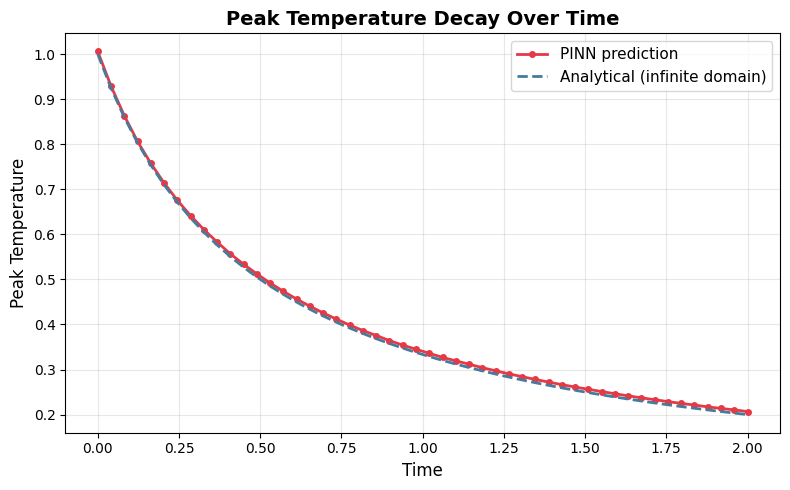

Saved: peak_decay.png


In [11]:
# ============================================================
# PLOT 2: Peak temperature decay over time
# ============================================================
def plot_peak_decay(params, network, L, T_final, alpha, sigma, N_eval=100):
    """Track how the maximum temperature decreases — should follow 1/(1 + 2αt/σ²) for a Gaussian."""
    
    N_times = 50
    times = jnp.linspace(0, T_final, N_times)
    peaks = []
    
    for t_val in times:
        _, _, U_pred = eval_on_grid(params, network, float(t_val), L, N_eval)
        peaks.append(float(jnp.max(U_pred)))
    
    # Analytical peak decay for an infinite-domain 2D Gaussian: u_max(t) = σ² / (σ² + 2αt)
    # This is approximate (ignores boundary effects) but good for comparison
    t_np = np.array(times)
    analytical_peak = sigma**2 / (sigma**2 + 2 * alpha * t_np)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(t_np, peaks, 'o-', color='#e63946', linewidth=2, markersize=4, label='PINN prediction')
    ax.plot(t_np, analytical_peak, '--', color='#457b9d', linewidth=2, 
            label=f'Analytical (infinite domain)')
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Peak Temperature', fontsize=12)
    ax.set_title('Peak Temperature Decay Over Time', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('peak_decay.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    print("Saved: peak_decay.png")




plot_peak_decay(params, network, L, T_final, alpha, sigma)


## Loss Curves

KeyboardInterrupt: 

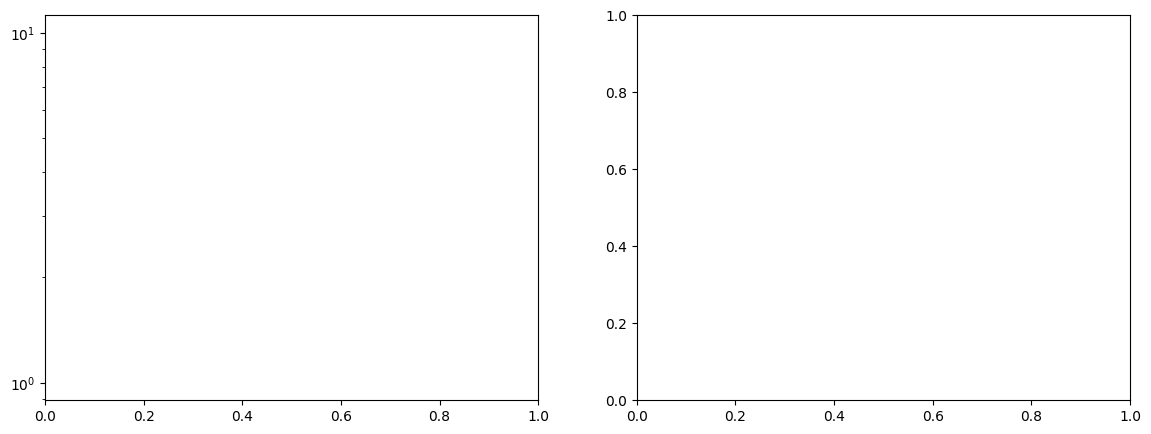

In [12]:
# ============================================================
# PLOT 3: Training loss curves (all 3 components)
# ============================================================
def plot_loss_curves(losses_ic, losses_bc, losses_physics, losses_total):
    """Plot individual loss components — essential for debugging."""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    iters = np.arange(1, len(losses_total) + 1)
    
    # Left: total loss (log scale)
    ax1.semilogy(iters, losses_total, color='black', linewidth=1.5, alpha=0.8)
    ax1.set_xlabel('Iteration', fontsize=12)
    ax1.set_ylabel('Total Loss', fontsize=12)
    ax1.set_title('Total Loss', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Right: individual components (log scale)
    ax2.semilogy(iters, losses_ic, label='IC Loss', linewidth=1.5, alpha=0.8, color='#e63946')
    ax2.semilogy(iters, losses_bc, label='BC Loss', linewidth=1.5, alpha=0.8, color='#457b9d')
    ax2.semilogy(iters, losses_physics, label='Physics Loss', linewidth=1.5, alpha=0.8, color='#2a9d8f')
    ax2.set_xlabel('Iteration', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title('Individual Loss Components', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('loss_curves.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    print("Saved: loss_curves.png")

plot_loss_curves(losses_ic, losses_bc, losses_physics, losses)

## Residual Heatmap

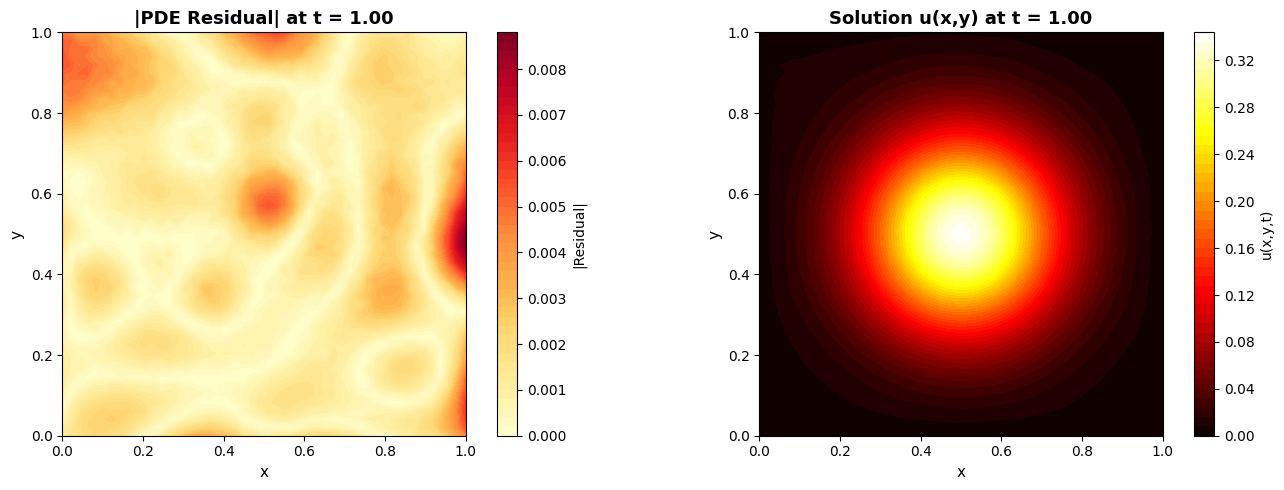

Saved: residual_heatmap.png


In [13]:
# ============================================================
# PLOT 4: Physics residual heatmap at a fixed time
# ============================================================
def plot_residual_heatmap(params, physics_residual_single, L, T_final, alpha, N_eval=50):
    """
    Show where the PDE residual is largest at t = T_final/2.
    You've done this for Burgers' — expect higher residuals where gradients are steep.
    """
    from jax import vmap
    
    t_mid = T_final / 2.0
    x_eval = jnp.linspace(0, L, N_eval)
    y_eval = jnp.linspace(0, L, N_eval)
    X, Y = jnp.meshgrid(x_eval, y_eval)
    x_flat = X.ravel()
    y_flat = Y.ravel()
    t_flat = jnp.full_like(x_flat, t_mid)
    
    # Vectorized residual computation
    residual_batch = vmap(physics_residual_single, in_axes=(None, 0, 0, 0, None))
    residuals = residual_batch(params, t_flat, x_flat, y_flat, alpha)
    R = residuals.reshape(N_eval, N_eval)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: absolute residual
    im1 = axes[0].contourf(np.array(X), np.array(Y), np.abs(np.array(R)),
                           levels=50, cmap='YlOrRd')
    axes[0].set_title(f'|PDE Residual| at t = {t_mid:.2f}', fontsize=13, fontweight='bold')
    axes[0].set_xlabel('x', fontsize=11)
    axes[0].set_ylabel('y', fontsize=11)
    axes[0].set_aspect('equal')
    fig.colorbar(im1, ax=axes[0], label='|Residual|')
    
    # Right: solution at the same time (for comparison)
    _, _, U_pred = eval_on_grid(params, lambda p, x: network(p, x), t_mid, L, N_eval)
    im2 = axes[1].contourf(np.array(X), np.array(Y), np.array(U_pred),
                           levels=50, cmap='hot')
    axes[1].set_title(f'Solution u(x,y) at t = {t_mid:.2f}', fontsize=13, fontweight='bold')
    axes[1].set_xlabel('x', fontsize=11)
    axes[1].set_ylabel('y', fontsize=11)
    axes[1].set_aspect('equal')
    fig.colorbar(im2, ax=axes[1], label='u(x,y,t)')
    
    plt.tight_layout()
    plt.savefig('residual_heatmap.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    print("Saved: residual_heatmap.png")

    
plot_residual_heatmap(params, physics_residual_single, L, T_final, alpha)

## Animated GIF

In [14]:
# ============================================================
# PLOT 5: Animated GIF of diffusion (optional but looks great)
# ============================================================
def create_diffusion_gif(params, network, L, T_final, N_eval=100, n_frames=60, filename='diffusion_2d.gif'):
    """Create an animated GIF of the Gaussian diffusing. Great for X posts."""
    from PIL import Image
    import os
    
    os.makedirs('gif_frames', exist_ok=True)
    times = jnp.linspace(0, T_final, n_frames)
    
    # Get color range from initial condition
    _, _, U_init = eval_on_grid(params, network, 0.0, L, N_eval)
    vmax = float(jnp.max(U_init)) * 1.05
    
    files = []
    for i, t_val in enumerate(times):
        X, Y, U_pred = eval_on_grid(params, network, float(t_val), L, N_eval)
        
        fig, ax = plt.subplots(figsize=(6, 5))
        im = ax.contourf(np.array(X), np.array(Y), np.array(U_pred),
                        levels=50, cmap='hot', vmin=0, vmax=vmax)
        ax.set_title(f'2D Diffusion  |  t = {float(t_val):.3f}', fontsize=14, fontweight='bold')
        ax.set_xlabel('x', fontsize=11)
        ax.set_ylabel('y', fontsize=11)
        ax.set_aspect('equal')
        fig.colorbar(im, label='u(x,y,t)')
        
        peak = float(jnp.max(U_pred))
        ax.text(0.05, 0.95, f'max = {peak:.3f}', transform=ax.transAxes,
               fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        filepath = f'gif_frames/frame_{i:04d}.png'
        plt.savefig(filepath, dpi=100, bbox_inches='tight', facecolor='white')
        files.append(filepath)
        plt.close()
    
    # Assemble GIF
    imgs = [Image.open(f) for f in files]
    imgs[0].save(filename, format='GIF', append_images=imgs[1:],
                save_all=True, duration=int(1000/20), loop=0)
    print(f"Saved: {filename} ({n_frames} frames)")


create_diffusion_gif(params, network, L, T_final)

Saved: diffusion_2d.gif (60 frames)


## 3D giff

In [16]:
"""
3D Surface Animation — 2D Diffusion PINN
==========================================
Shows the Gaussian peak flattening over time as a rotating 3D surface.
Drop into notebook after training.
"""

import jax.numpy as jnp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from PIL import Image
import os


def eval_on_grid(params, network, t_val, L, N_eval=80):
    """Evaluate u(x, y, t_val) on a grid."""
    x_eval = jnp.linspace(0, L, N_eval)
    y_eval = jnp.linspace(0, L, N_eval)
    X, Y = jnp.meshgrid(x_eval, y_eval)
    x_flat = X.ravel().reshape(-1, 1)
    y_flat = Y.ravel().reshape(-1, 1)
    t_flat = jnp.full_like(x_flat, t_val)
    
    txy = jnp.concatenate([t_flat, x_flat, y_flat], axis=1)
    U_pred = network(params, txy).reshape(N_eval, N_eval)
    
    return np.array(X), np.array(Y), np.array(U_pred)


def create_3d_diffusion_gif(params, network, L, T_final, 
                             N_eval=80, n_frames=80, 
                             filename='diffusion_3d.gif',
                             rotate=True):
    """
    Animated 3D surface plot of the Gaussian diffusing.
    
    Args:
        rotate: If True, camera slowly rotates around the surface for a cinematic effect.
    """
    os.makedirs('gif_frames_3d', exist_ok=True)
    
    times = jnp.linspace(0, T_final, n_frames)
    
    # Get initial peak for consistent z-axis
    _, _, U_init = eval_on_grid(params, network, 0.0, L, N_eval)
    z_max = float(np.max(U_init)) * 1.1
    
    files = []
    for i, t_val in enumerate(times):
        X, Y, U = eval_on_grid(params, network, float(t_val), L, N_eval)
        
        fig = plt.figure(figsize=(9, 7))
        ax = fig.add_subplot(111, projection='3d')
        
        # Surface plot with color mapping
        surf = ax.plot_surface(
            X, Y, U,
            cmap='hot',
            vmin=0, vmax=z_max,
            edgecolor='none',
            alpha=0.95,
            rstride=2, cstride=2  # Slightly coarser mesh for smoother look
        )
        
        # Fixed z-axis so you see the peak dropping
        ax.set_zlim(0, z_max)
        ax.set_xlim(0, L)
        ax.set_ylim(0, L)
        
        # Labels
        ax.set_xlabel('x', fontsize=11, labelpad=8)
        ax.set_ylabel('y', fontsize=11, labelpad=8)
        ax.set_zlabel('u(x,y,t)', fontsize=11, labelpad=8)
        
        peak = float(np.max(U))
        ax.set_title(f'2D Diffusion  |  t = {float(t_val):.3f}  |  peak = {peak:.3f}',
                     fontsize=13, fontweight='bold', pad=15)
        
        # Camera angle: slowly rotate if enabled
        elevation = 30
        if rotate:
            # Rotate 90 degrees over the full animation
            azimuth = 220 + (i / n_frames) * 90
        else:
            azimuth = 220
        ax.view_init(elev=elevation, azim=azimuth)
        
        # Clean up the axes a bit
        ax.tick_params(labelsize=8)
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        ax.xaxis.pane.set_edgecolor('lightgrey')
        ax.yaxis.pane.set_edgecolor('lightgrey')
        ax.zaxis.pane.set_edgecolor('lightgrey')
        
        filepath = f'gif_frames_3d/frame_{i:04d}.png'
        plt.savefig(filepath, dpi=120, bbox_inches='tight', facecolor='white')
        files.append(filepath)
        plt.close()
        
        if (i + 1) % 20 == 0:
            print(f"  Frame {i+1}/{n_frames}")
    
    # Assemble GIF
    imgs = [Image.open(f) for f in files]
    imgs[0].save(filename, format='GIF', append_images=imgs[1:],
                save_all=True, duration=int(1000 / 20), loop=0)
    print(f"\nSaved: {filename} ({n_frames} frames, {n_frames/20:.1f}s)")


# create_3d_diffusion_gif(params, network, L, T_final)
#
# For no rotation (fixed camera):
# create_3d_diffusion_gif(params, network, L, T_final, rotate=False)
#
# For more frames (smoother but slower):
create_3d_diffusion_gif(params, network, L, T_final, n_frames=120)

  Frame 20/120
  Frame 40/120
  Frame 60/120
  Frame 80/120
  Frame 100/120
  Frame 120/120

Saved: diffusion_3d.gif (120 frames, 6.0s)
